Loading data from /data folder...
Loaded Building_A.csv → 35064 rows
Loaded Building_B.csv → 35064 rows
Loaded Building_C.csv → 35064 rows

Success! Combined 105192 records from 3 buildings
Date range: 2015-01-01 to 2018-12-31

Creating dashboard...


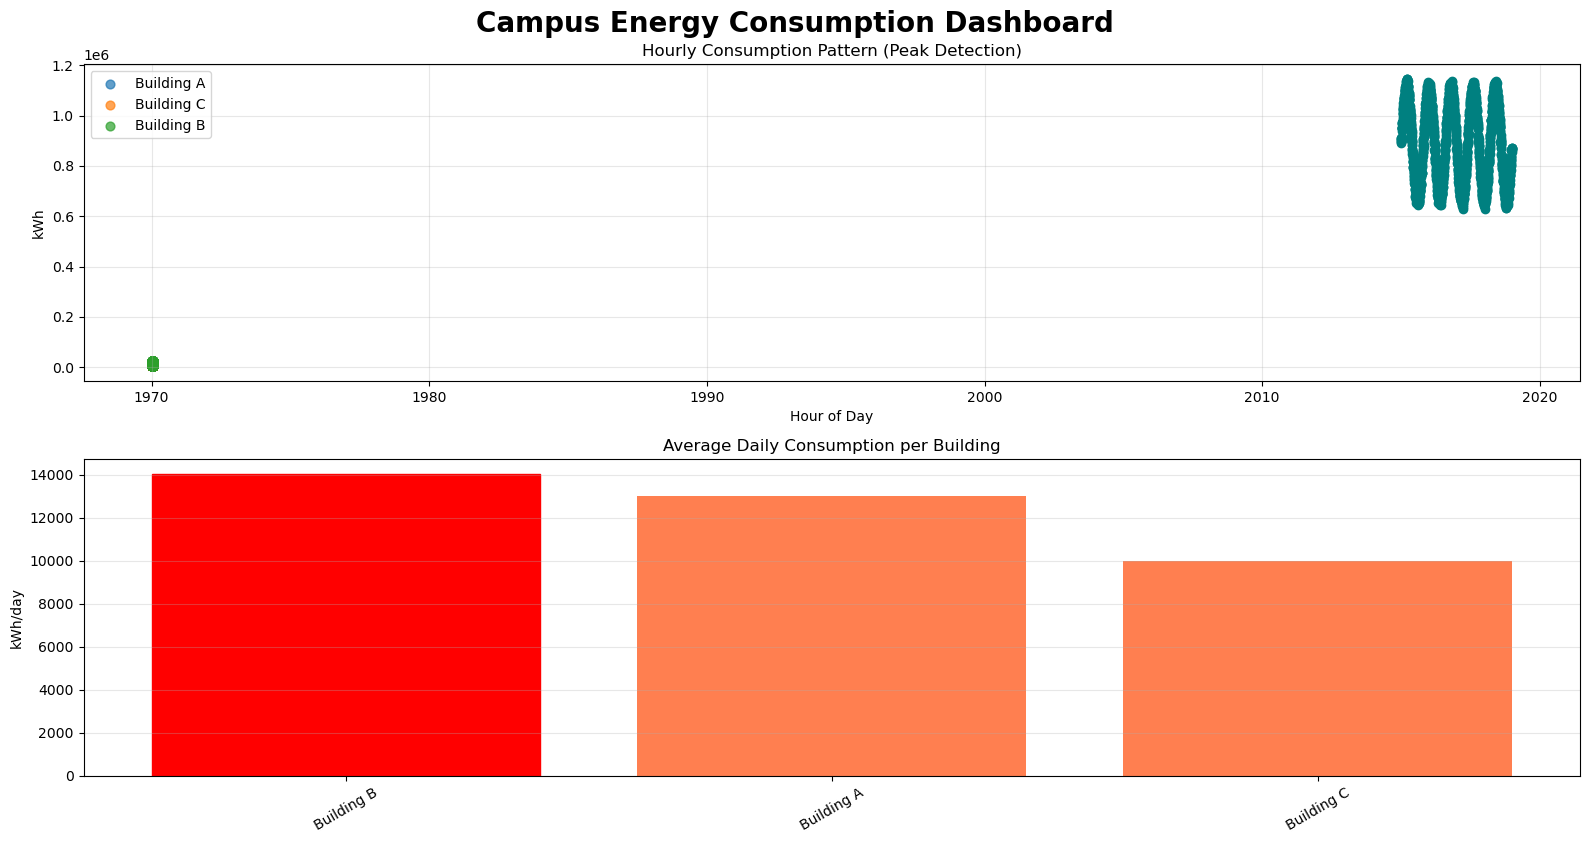


All done!
Files created → output/cleaned_energy_data.csv
              → output/building_summary.csv
              → output/summary.txt
              → dashboard.png (also saved in output/)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

# Create folders
Path("data").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)

# ------------------- TASK 1: Load all CSV files -------------------
print("Loading data from /data folder...")

data_folder = Path("data")
csv_files = list(data_folder.glob("*.csv"))

if not csv_files:
    print("No CSV files found in 'data' folder!")
    exit()

all_data = []

for file in csv_files:
    try:
        df = pd.read_csv(file)

        # Auto-detect timestamp and kWh columns
        time_col = [c for c in df.columns if c.lower() in ['timestamp','date','datetime','time']][0]
        kwh_col  = [c for c in df.columns if c.lower() in ['kwh','consumption','reading','energy','usage']][0]

        df = df[[time_col, kwh_col]].copy()
        df.columns = ['timestamp', 'kwh']
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df['building'] = file.stem.replace("_", " ").title()   # nice building name

        all_data.append(df)
        print(f"Loaded {file.name} → {len(df)} rows")

    except Exception as e:
        print(f"Could not load {file.name}: {e}")

# Combine everything
df_combined = pd.concat(all_data, ignore_index=True)
df_combined = df_combined.sort_values('timestamp').reset_index(drop=True)

print(f"\nSuccess! Combined {len(df_combined)} records from {df_combined['building'].nunique()} buildings")
print(f"Date range: {df_combined['timestamp'].min().date()} to {df_combined['timestamp'].max().date()}\n")

# ------------------- TASK 2: Aggregations -------------------
df = df_combined.set_index('timestamp')

daily_total = df['kwh'].resample('D').sum().reset_index()
daily_total['date'] = daily_total['timestamp'].dt.date

building_summary = df.groupby('building')['kwh'].agg(
    total_kwh = 'sum',
    avg_daily_kwh = 'mean',
    max_kwh = 'max',
    readings = 'count'
).round(2).sort_values('total_kwh', ascending=False)

# ------------------- TASK 3: OOP Classes (Simple & Correct) -------------------
class MeterReading:
    def __init__(self, timestamp, kwh):
        self.timestamp = pd.to_datetime(timestamp)
        self.kwh = float(kwh)

class Building:
    def __init__(self, name):
        self.name = name
        self.readings = []

    def add_reading(self, timestamp, kwh):
        self.readings.append(MeterReading(timestamp, kwh))

    def total_consumption(self):
        return sum(r.kwh for r in self.readings)

class BuildingManager:
    def __init__(self):
        self.buildings = {}

    def load_from_df(self, data_df):
        for building_name in data_df['building'].unique():
            self.buildings[building_name] = Building(building_name)

        for _, row in data_df.iterrows():
            self.buildings[row['building']].add_reading(row['timestamp'], row['kwh'])

    def campus_total(self):
        return sum(b.total_consumption() for b in self.buildings.values())

    def top_building(self):
        return max(self.buildings.items(), key=lambda x: x[1].total_consumption())

# Use the classes
manager = BuildingManager()
manager.load_from_df(df_combined)

# ------------------- TASK 4: Dashboard Visualization -------------------
print("Creating dashboard...")

plt.rcParams['figure.figsize'] = (16, 12)
fig = plt.figure()
fig.suptitle('Campus Energy Consumption Dashboard', fontsize=20, fontweight='bold')

# 1. Daily trend
ax1 = plt.subplot(3, 1, 1)
ax1.plot(daily_total['date'], daily_total['kwh'], marker='o', color='teal', linewidth=2)
ax1.set_title('Daily Total Consumption (All Buildings)')
ax1.set_ylabel('kWh')
ax1.grid(True, alpha=0.3)

# 2. Average daily per building
ax2 = plt.subplot(3, 1, 2)
bars = ax2.bar(building_summary.index, building_summary['avg_daily_kwh'], color='coral')
ax2.set_title('Average Daily Consumption per Building')
ax2.set_ylabel('kWh/day')
ax2.tick_params(axis='x', rotation=30)
ax2.grid(True, axis='y', alpha=0.3)

# Highlight the top building
bars[0].set_color('red')

# 3. Hourly pattern scatter
ax3 = plt.subplot(3, 1, 1)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
for i, building in enumerate(df_combined['building'].unique()):
    subset = df_combined[df_combined['building'] == building]
    ax3.scatter(subset['timestamp'].dt.hour, subset['kwh'], 
                label=building, alpha=0.7, s=40, color=colors[i % len(colors)])

ax3.set_title('Hourly Consumption Pattern (Peak Detection)')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('kWh')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard.png', dpi=300, bbox_inches='tight')
plt.savefig('output/dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# ------------------- TASK 5: Export Files & Report -------------------
df_combined.to_csv('output/cleaned_energy_data.csv', index=False)
building_summary.to_csv('output/building_summary.csv')

total_campus = manager.campus_total()
top_name, top_obj = manager.top_building()
peak_hour = df_combined['timestamp'].dt.hour.mode()[0]

with open('output/summary.txt', 'w') as f:
    f.write("CAMPUS ENERGY CONSUMPTION REPORT\n")
    f.write("="*50 + "\n\n")
    f.write(f"Generated on      : {datetime.now():%Y-%m-%d %H:%M}\n")
    f.write(f"Total Consumption : {total_campus:,.2f} kWh\n")
    f.write(f"Top Building      : {top_name} ({top_obj.total_consumption():,.2f} kWh)\n")
    f.write(f"Peak Hour         : {peak_hour}:00 – {peak_hour+1}:00\n")
    f.write(f"Buildings         : {len(building_summary)}\n")

print("\nAll done!")
print("Files created → output/cleaned_energy_data.csv")
print("              → output/building_summary.csv")
print("              → output/summary.txt")
print("              → dashboard.png (also saved in output/)")